# EDA
* 각 데이터 시트별로 살펴보겠습니다.

## 모듈 로드

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 400)

## 데이터 로드

In [4]:
path = './data/'

In [142]:
data = pd.read_csv('./data_feature_engineering/train_test_v5.csv')

In [143]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325540 entries, 0 to 325539
Data columns (total 11 columns):
card_id                                 325540 non-null object
feature_1                               325540 non-null int64
feature_2                               325540 non-null int64
feature_3                               325540 non-null int64
first_active_month                      325540 non-null int64
outliers                                201917 non-null float64
target                                  201917 non-null float64
first_active                            325540 non-null object
first_active_year                       325540 non-null int64
first_active_elapsed_time_from_trade    325540 non-null int64
first_active_total_day                  325540 non-null float64
dtypes: float64(3), int64(6), object(2)
memory usage: 27.3+ MB


In [144]:
train = data[data.target.notnull()]
test = data[data.target.isnull()]

In [145]:
train.head()

,card_id,feature_1,feature_2,feature_3,first_active_month,outliers,target,first_active,first_active_year,first_active_elapsed_time_from_trade,first_active_total_day
0,C_ID_92a2005557,5,2,1,6,0.0,-0.820283,2017-06-01,2017,333,17318.0
1,C_ID_3d0044924f,4,1,0,1,0.0,0.392913,2017-01-01,2017,484,17167.0
2,C_ID_d639edf6cd,2,2,0,8,0.0,0.688056,2016-08-01,2016,637,17014.0
3,C_ID_186d6a6901,4,3,0,9,0.0,0.142495,2017-09-01,2017,241,17410.0
4,C_ID_cdbd2c0db2,1,3,0,11,0.0,-0.159749,2017-11-01,2017,180,17471.0


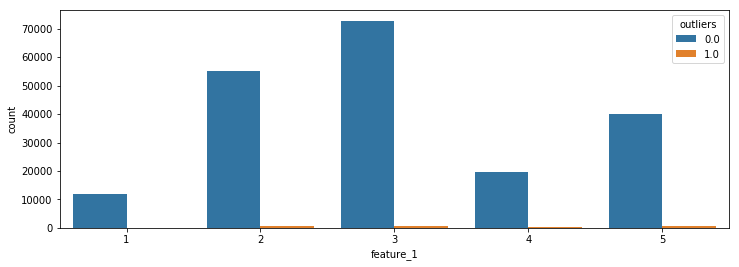

In [112]:
f, ax = plt.subplots(figsize=(12, 4))
sns.countplot(x='feature_1', hue='outliers',data=train)
plt.show()

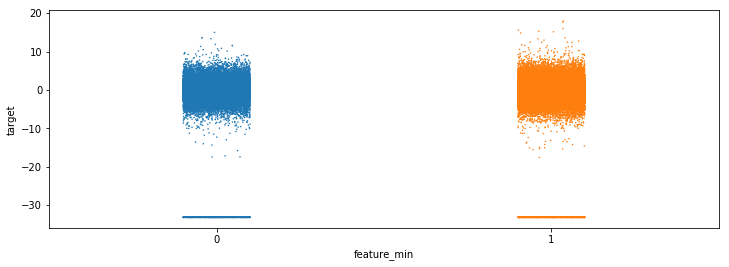

In [113]:
f, ax = plt.subplots(figsize=(12, 4))
sns.stripplot(train.feature_min, train.target, size=1.5)

In [114]:
feature = 'feature_2'
train[feature].value_counts() / (test[feature].value_counts() + train[feature].value_counts())

1    0.619663
2    0.619364
3    0.623420
Name: feature_2, dtype: float64

In [115]:
test.feature_1.value_counts() / (test.feature_1.value_counts() + train.feature_1.value_counts())

3    0.378039
2    0.379427
5    0.381433
4    0.382779
1    0.380908
Name: feature_1, dtype: float64

## model

In [131]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, StratifiedKFold

In [132]:
FEATS_EXCLUDED = ['first_active', 'card_id', 'target', 'outliers']

In [133]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

In [134]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=train.iloc[trn_idx]['target'])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=train.iloc[val_idx]['target'])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(mean_squared_error(train.target.values, oof_lgb)**0.5))

fold n°0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.83805	valid_1's rmse: 3.8458
[200]	training's rmse: 3.83542	valid_1's rmse: 3.84603
Early stopping, best iteration is:
[135]	training's rmse: 3.83677	valid_1's rmse: 3.84559
fold n°1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.83807	valid_1's rmse: 3.84598
[200]	training's rmse: 3.83563	valid_1's rmse: 3.84567
Early stopping, best iteration is:
[148]	training's rmse: 3.83652	valid_1's rmse: 3.84553
fold n°2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.84099	valid_1's rmse: 3.83429
[200]	training's rmse: 3.83843	valid_1's rmse: 3.8343
Early stopping, best iteration is:
[134]	training's rmse: 3.83976	valid_1's rmse: 3.83402
fold n°3
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.83873	valid_1's rmse: 3.8435
[200]	training's rmse: 3.83619	valid_1's rmse: 3.84336
Early

In [135]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

In [136]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1)
rf = Lasso(alpha=0.01)

In [139]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb = np.zeros(len(train))
feature_importance = pd.DataFrame()

train_columns = [f for f in train.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    x_train = train.iloc[trn_idx][train_columns]
    y_train = train.iloc[trn_idx]['target']
    
    x_val = train.iloc[val_idx][train_columns]
    y_val = train.iloc[val_idx]['target']

    rf.fit(x_train, y_train)
    oof_lgb[val_idx] = rf.predict(x_val)
    print("CV score: {:<8.5f}".format(mean_squared_error(y_val.values, oof_lgb[val_idx])**0.5))
#     fold_importance = pd.DataFrame()
#     fold_importance["Feature"] = train_columns
#     fold_importance["importance"] = rf.feature_importance()
#     fold_importance["fold"] = fold_ + 1
#     feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(mean_squared_error(train.target.values, oof_lgb)**0.5))

fold n°0
CV score: 3.84837 
fold n°1
CV score: 3.84874 
fold n°2
CV score: 3.83524 
fold n°3
CV score: 3.84569 
fold n°4
CV score: 3.84478 
CV score: 3.84457 


In [140]:
rf.coef_

array([-0.00000000e+00, -0.00000000e+00,  4.71551532e-15,  2.55186106e-02,
       -0.00000000e+00,  7.37424197e-03, -1.87613626e-03,  9.12473545e-03,
       -5.81152568e-04,  1.01512887e-16, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.67413096e-02,  8.26460977e-03,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00])